Unbalanced Optimal Transport
=========================================

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$

This numerical tour details how to perform "unbalanced" OT, which allows one to compare measures with different total mass, and also leads to more regular transportation plans by enabling creation/destruction of mass. This extension of classicl ("balanced") OT is crucial for applications of OT to imaging sciences and machine learning, since it makes OT more robust to noise and outliers. The modification with respect to the usual OT is very minor, since it corresponds a penalization of the mass conservation constraint.

The original idea can be found in the paper of [Matthias Liero, Alexander Mielke and Giuseppe Savaré](https://arxiv.org/abs/1508.07941). The entropic regularized version with the corresponding Sinkhorn's algorithm can be found in the paper of [Lenaic Chizat, Gabriel Peyré, Bernhard Schmitzer and François-Xavier Vialard](https://arxiv.org/abs/1607.05816).

You need to install [CVXPY](https://www.cvxpy.org/). _Warning:_ seems to not be working on Python 3.7, use rather 3.6.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

Definition of the input measures
------------------------------------------

For the sake of concreteness and to ease the display, we consider the transport between 1D distributions. But this can be applied to any OT problem.

We consider two dicretes distributions
$$ \sum_{i=1}^n a_i \de_{x_i} \qandq 
   \sum_{j=1}^m b_j \de_{y_j}, $$
where $n,m$ are the number of points, $\de_x$ is the Dirac at
location $x$, and $(x_i)_i, (y_j)_j$ are the positions of the diracs (in some metric space, in the following we consider the space to be $\RR$).

In [3]:
n = int(120)
m = int(110)

We consider two Gaussian measures sampled on a 1-D grid.

In [4]:
Gaussian = lambda t0,sigma,N: np.exp(-(np.arange(0,N)/N-t0)**2/(2*sigma**2))
normalize = lambda p: p/np.sum(p)
sigma = .06;
a = Gaussian(.25,sigma,n)
b = Gaussian(.8,sigma,m)

Add some minimal mass and normalize. Here we do not use the same total mass for $a$ and $b$.

In [5]:
vmin = .01;
a = 0.95*normalize( a+np.max(a)*vmin)
b = 1.05*normalize( b+np.max(b)*vmin)
x = np.arange(0,n)/n
y = np.arange(0,m)/m

Display the histograms.

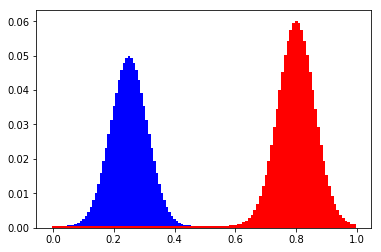

In [6]:
plt.bar(x, a, width = 1/n, color = "b")
plt.bar(y, b, width = 1/m, color = "r");

Compute the cost matrix, here we use Euclidean distance squared, $C_{i,j} = \norm{x_i-x_j}^2$.

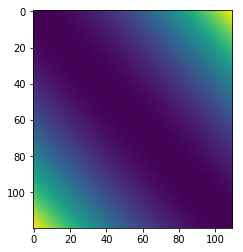

In [7]:
C = np.abs(x[:,None]-y[None,:])**2
plt.imshow(C);

Kantorovitch-Hellinger / Wasserstein-Fisher-Rao Transport
------------------------------------------

The unbalanced OT problem corresponds to
$$
    W_\rho(a,b) \triangleq \umin{P \in \RR_+^{n \times m}} \dotp{P}{C}
    + \rho D_\phi( P 1_m|a )
    + \rho D_\phi( P^\top  1_n|b ), 
$$

where here $D_\phi$ is a so-called [Cizarr f-divergence](https://en.wikipedia.org/wiki/F-divergence)
$$
    D_\phi(h|b) \triangleq \sum_{i} \phi(h_i/b_i) b_i.
$$

The most well known are the KL divergence obaind when using $\phi(s)=s \log(s)-s+1$ and the total variation for $\phi(s)=|s-1|$. These are the two examples we will consider in this tour.

The parameter $\rho$ controls the amount of mass conservation relaxation. When $\rho \rightarrow +\infty$ one recovers the usual (balanced) OT. When $\rho \rightarrow 0$, no transport is performed. 

Define the optimiztion variable $P$, the OT coupling.

In [8]:
P = cp.Variable((n,m))

We first consider the case of $\phi(s)=s \log(s)-s+1$, in which case the unbalanced OT problem is called either "Kantorovitch-Hellinger" or "Wasserstein-Fisher-Rao".

In this case, assuming $n=m$ and that the sampling points are equal, $x_i=y_i$, one has that $W_\rho/\rho$ converges toward the squared Hellinger distance as $\rho \to +\infty$
$$
    W_\rho(a,b)/\rho \longrightarrow \sum_{i} (\sqrt{a_i}-\sqrt{b_i})^2.
$$

We define the CVXPY problem and solve it.

In [9]:
u = np.ones((n,1))
v = np.ones((m,1))
q = cp.sum( cp.kl_div(cp.matmul(P,v),a[:,None]) )
r = cp.sum( cp.kl_div(cp.matmul(P.T,u),b[:,None]) )

constr = [0 <= P]
# uncomment to perform balanced OT
#constr = [0 <= P, cp.matmul(P,u)==a[:,None], cp.matmul(P.T,v)==b[:,None]]

rho = .1
objective = cp.Minimize( cp.sum(cp.multiply(P,C)) + rho*q + rho*r )

prob = cp.Problem(objective, constr)
result = prob.solve()

Display the solution coupling.

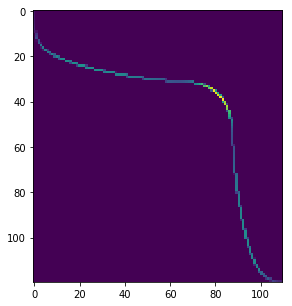

In [10]:
def remap_plan(P): # boost contrast
    return np.log(.001+P)
plt.figure(figsize = (5,5))
plt.imshow(remap_plan(P.value));

Display the marginals.

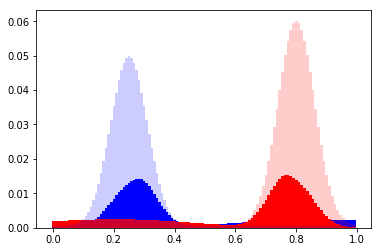

In [11]:
a1 = np.sum(P.value, axis=1)
b1 = np.sum(P.value.T, axis=1)
plt.bar(x, a1, width = 1/n, color = "b")
plt.bar(y, b1, width = 1/m, color = "r")
plt.bar(x, a, width = 1/n, color = "b", alpha=.2)
plt.bar(y, b, width = 1/m, color = "r", alpha=.2);

Shows the impact of $\rho$ on the solution.

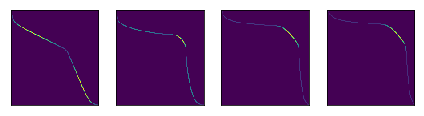

In [12]:
rho_list = np.array([.03, .1, .5, 1])
for k in range(len(rho_list)):
    rho = rho_list[k]
    objective = cp.Minimize( cp.sum(cp.multiply(P,C)) + rho*q + rho*r )
    prob = cp.Problem(objective, constr)
    result = prob.solve()
    ax = plt.subplot(1,len(rho_list),k+1)
    plt.imshow(remap_plan(P.value));
    ax.set(xticks=[], yticks=[])
plt.tight_layout()

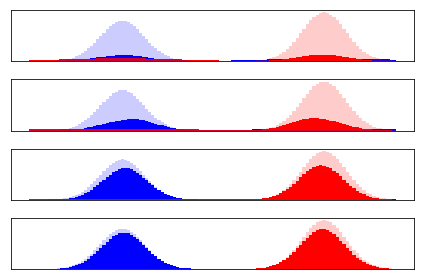

In [13]:
for k in range(len(rho_list)):
    rho = rho_list[k]
    objective = cp.Minimize( cp.sum(cp.multiply(P,C)) + rho*q + rho*r )
    prob = cp.Problem(objective, constr)
    result = prob.solve()
    a1 = np.sum(P.value, axis=1)
    b1 = np.sum(P.value.T, axis=1)
    ax = plt.subplot(len(rho_list),1,k+1)
    plt.bar(x, a1, width = 1/n, color = "b")
    plt.bar(y, b1, width = 1/m, color = "r")
    plt.bar(x, a, width = 1/n, color = "b", alpha=.2)
    plt.bar(y, b, width = 1/m, color = "r", alpha=.2)
    ax.set(xticks=[], yticks=[])
plt.tight_layout()

Partial Optimal Transport
=========

We can consider other divergences, such as the total variation, which corresponds to the $\ell^1$ norm of densities, obtained for $\phi(s)=|s-1|$
$$
    D_\phi(h|a) = \norm{a-h}_1 = \sum_i |a_i-h_i|.
$$
The resulting OT problem corresponds to a penalized version of the celebrated partial transport problem. In sharp contrast to the KL problem, this partial OT either transport the mass or detroys it.

In [14]:
q = cp.sum( cp.abs(cp.matmul(P,v)-a[:,None]) )
r = cp.sum( cp.abs(cp.matmul(P.T,u)-b[:,None]) )

Display the marginals of the optimal plan. One can see the presence of small spikes, which 
are caused by the discretization of the problem. We have displayed up-side down the densities to 
highlight that these error actually almost cancel.

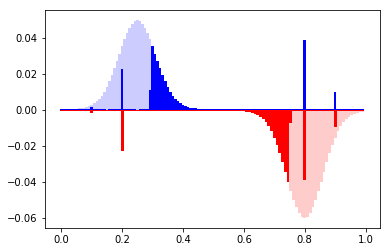

In [15]:
rho =.1
objective = cp.Minimize( cp.sum(cp.multiply(P,C)) + rho*q + rho*r )
prob = cp.Problem(objective, constr)
result = prob.solve()
a1 = np.sum(P.value, axis=1)
b1 = np.sum(P.value.T, axis=1)
plt.bar(x, a1, width = 1/n, color = "b")
plt.bar(y, -b1, width = 1/m, color = "r")
plt.bar(x, a, width = 1/n, color = "b", alpha=.2)
plt.bar(y,-b, width = 1/m, color = "r", alpha=.2);

Display the impact of $\rho$.

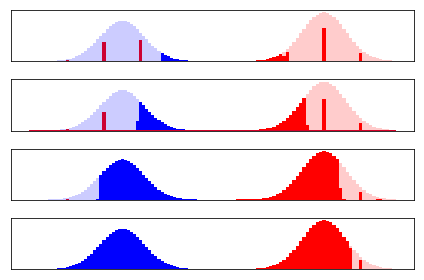

In [16]:
rho_list = np.array([.05, .1, .2, 5])
for k in range(len(rho_list)):
    rho = rho_list[k]
    objective = cp.Minimize( cp.sum(cp.multiply(P,C)) + rho*q + rho*r )
    prob = cp.Problem(objective, constr)
    result = prob.solve()
    a1 = np.sum(P.value, axis=1)
    b1 = np.sum(P.value.T, axis=1)
    ax = plt.subplot(len(rho_list),1,k+1)
    plt.bar(x, a1, width = 1/n, color = "b")
    plt.bar(y, b1, width = 1/m, color = "r")
    plt.bar(x, a, width = 1/n, color = "b", alpha=.2)
    plt.bar(y, b, width = 1/m, color = "r", alpha=.2)
    ax.set(xticks=[], yticks=[])
plt.tight_layout()

We can compare several $\phi$-divergence.

Entropic Regularization and Sinkhorn
=========

It is possible to regularized the initial problem using entropic regularization and consider
$$
\umin{P \in \RR_+^{n \times m}} \dotp{P}{C}
    + \rho KL( P 1_m|a )
    + \rho KL( P^\top  1_n|b )
    + \varepsilon KL(P|ab^\top).
$$
Here $\varepsilon>0$ controls the strength of the regularization, increasing it results in faster algorithms but degrades the approximation.

The solution $P$ can be shown to be of the form 
$$
    P_{i,j} = e^{ \frac{f_i+g_j-C_{i,j}}{\epsilon} } a_i b_j
$$
where the dual variables $f \in \RR^n, g \in \RR^m$ satisfies the following scaled Sinkhorn iterations (written here in log domain):
$$
    f_i = -\varepsilon \kappa \log \sum_{j} \exp\pa{ \frac{g_j-C_{i,j}}{\epsilon} } b_j
$$
$$
    g_j = -\varepsilon\kappa \log \sum_{i} \exp\pa{ \frac{f_i-C_{i,j}}{\epsilon} } a_j
$$
where we noted
$$
    \kappa \triangleq  \frac{\rho}{\varepsilon + \rho} .
$$
Sinkhorn's algoritm simply iterates these two fixed points. 


We define the log-sum-exp operator (which corresponds to soft $C$-transforms).

In [17]:
def mina_u(H,epsilon): return -epsilon*np.log( np.sum(a[:,None] * np.exp(-H/epsilon),0) )
def minb_u(H,epsilon): return -epsilon*np.log( np.sum(b[None,:] * np.exp(-H/epsilon),1) )

 They can be stabilized using the usual [log-sum-exp trick](https://en.wikipedia.org/wiki/LogSumExp#log-sum-exp_trick_for_log-domain_calculations).

In [18]:
def mina(H,epsilon): return mina_u(H-np.min(H,0),epsilon) + np.min(H,0);
def minb(H,epsilon): return minb_u(H-np.min(H,1)[:,None],epsilon) + np.min(H,1);

Values of $\varepsilon, \rho$ and $\kappa$.

In [19]:
epsilon = .001
rho = .2
kappa = rho/(rho+epsilon)

Implement Sinkhorn's iterates.

In [20]:
f = np.zeros(n)
niter = 1000
for it in range(niter):
    g = kappa*mina(C-f[:,None],epsilon)
    f = kappa*minb(C-g[None,:],epsilon)
# generate the coupling
P = a[:,None] * np.exp((f[:,None]+g[None,:]-C)/epsilon) * b[None,:]

Display the optimal plan.

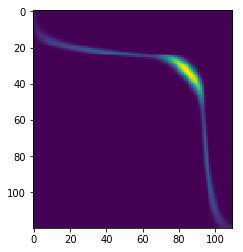

In [21]:
plt.imshow(remap_plan(P))

Display the marginals.

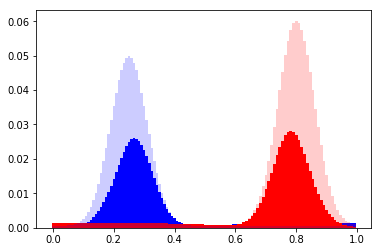

In [22]:
a1 = np.sum(P, axis=1)
b1 = np.sum(P.T, axis=1)
plt.bar(x, a1, width = 1/n, color = "b")
plt.bar(y, b1, width = 1/m, color = "r")
plt.bar(x, a, width = 1/n, color = "b", alpha=.2)
plt.bar(y, b, width = 1/m, color = "r", alpha=.2);

**Exercise (easy):** Experiments with different values of $\varepsilon$ and $\rho$. Study the rate of convergence of the method.

**Exercise (hard):** Extend Sinkhorn for other type of divergence, starting with TV.